In [1]:
import sys

sys.path.insert(0, '../')

from modules.VT_dataset import *
from modules.train_prep import *
from modules.plot_results import *

In [2]:
class EEGCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 40), padding=(1, 20))  # Preserves time dimension
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 25), padding=(1, 12))  # Preserves time dimension
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 10), padding=(1, 5))  # Preserves time dimension
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d((2, 4))  # Reduces height by 2, width by 4
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Calculating the output dimensions after pooling:
        # Initial input shape: (1, 129, 1250)
        # After first pool: (16, 65, 312)
        # After second pool: (32, 33, 78)
        # After third pool: (64, 17, 20)
        self.fc1 = nn.Linear(19456, 100)  # 64 channels, height 17, width 20
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [3]:
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_device)
elif torch.backends.mps.is_available():
    mps_device = torch.device("mps")

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

# Setup datasets and loaders
dsets = {
    'train': RawDataset(train_dir, train_behav_file, data_transforms['train']),
    'val': RawDataset(val_dir, val_behav_file, data_transforms['val'])
}
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val']}

dset_loaders = {}
for split in ['train', 'val']:
    targets = np.array([dsets[split].get_label(i) for i in range(len(dsets[split]))])
    class_counts = dsets[split].get_class_counts()
    class_weights = np.array([1.0 / class_counts[label] if class_counts[label] > 0 else 0 for label in targets])
    sampler = WeightedRandomSampler(class_weights, num_samples=len(class_weights), replacement=True)
    dset_loaders[split] = torch.utils.data.DataLoader(dsets[split], batch_size=b_size, num_workers=0, sampler=sampler)
    print('done making loader:', split)

# Initialize model, criterion, and optimizer
model_ft = EEGCNN(num_classes=4)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-5)

# Device configuration with MPS support
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model_ft.to(device)
criterion.to(device)
print(f"Training on {device}")

# Train model
model_ft, accuracies, losses, preds, labels = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dset_loaders, dset_sizes, num_epochs=n_epochs)

100%|██████████| 192/192 [00:05<00:00, 32.77it/s]


Class counts:  {'HEHF': 2489, 'HELF': 238, 'LEHF': 1371, 'LELF': 878}


100%|██████████| 48/48 [00:01<00:00, 27.14it/s]


Class counts:  {'HEHF': 508, 'HELF': 101, 'LEHF': 535, 'LELF': 100}
done making loader: train
done making loader: val
Training on mps


----------
Epoch 0/0
----------
LR is set to 0.0001

In train phase:


2490it [01:18, 31.55it/s]                          


train Loss: 1.3785 Acc: 0.3348

In val phase:


625it [00:15, 40.52it/s]                         
100%|██████████| 1/1 [01:34<00:00, 94.37s/it]

val Loss: 1.5727 Acc: 0.3232
New best accuracy = 0.3232
Training complete in 1m 34s
Best val Acc: 0.3232


train accuracies by epoch: [tensor(0.3348, device='mps:0')]
train losses by epoch: [1.3784711733699995]
val accuracies by epoch: [tensor(0.3232, device='mps:0')]
val losses by epoch: [1.5726604628409604]


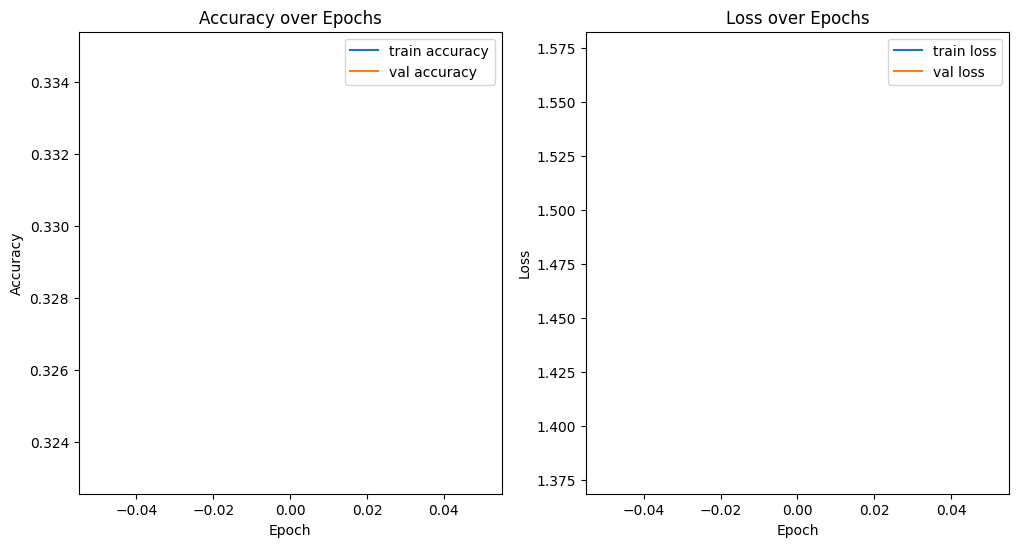

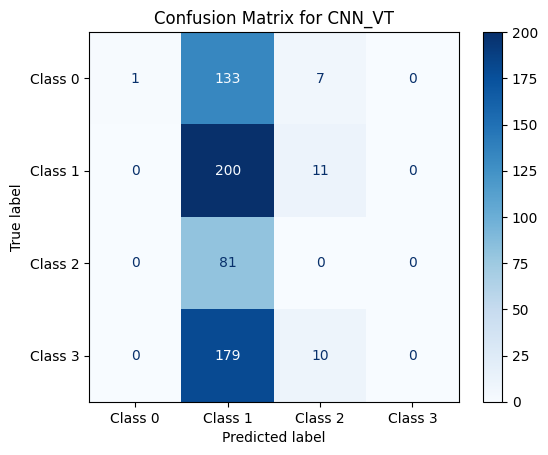

In [4]:
# Output results
for split in ['train', 'val']:
    print(split, 'accuracies by epoch:', accuracies[split])
    print(split, 'losses by epoch:', losses[split])

for key, value in accuracies.items():
    new_value = [v.cpu().numpy() for v in value]
    accuracies[key] = new_value

torch.save(model_ft.state_dict(), '../models/CNN_VT_best_model.pt')

plot_training_history(accuracies, losses, 'CNN_VT')
plot_confusion_matrix(labels, preds, 'CNN_VT')